In [1]:
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

c:\Users\kutay\miniconda3\envs\deepl\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.FashionMNIST(root='data', train=False, download=True, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False)

In [3]:
class Autoencoder(nn.Module):

    def __init__(self, input_shape=(28, 28)):
        super(Autoencoder, self).__init__()
        self.input_shape = input_shape
        self.encoder = nn.Sequential(
            nn.Linear(input_shape[0] * input_shape[1], 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 8),
            nn.ReLU(),
            nn.Linear(8, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_shape[0] * input_shape[1]),
            nn.Tanh()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.encoder(x)
        x = self.decoder(x)

        x = x.view(x.size(0), *self.input_shape)
        return x

In [4]:
def plot_images(inputs, outputs, epoch):
    plt.figure(figsize=(20, 4))
    for i in range(10):
        plt.subplot(2, 10, i + 1)
        plt.imshow(inputs[i].cpu().detach().numpy().squeeze(), cmap='gray')  
        plt.title('Original')
        plt.axis('off')
        
        plt.subplot(2, 10, i + 11)
        plt.imshow(outputs[i].cpu().detach().numpy().squeeze(), cmap='gray')  
        plt.title('Reconstructed')
        plt.axis('off')
    plt.suptitle(f"Epoch {epoch}")
    plt.show()

def add_white_noise(x, factor=0.5, stddev=1):
    """ Adds white noise to an input tensor.
    To make sure that data is in intended range [min, max], use torch.clamp(x, min, max) after applying this function.

    :param x: ND Tensor that is altered
    :param factor: A factor that controls the strength of the additive noise
    :param stddev: The stddev of the normal distribution used for generating the noise
    :return: ND Tensor, x with white noise
    """
    # add white noise to tensor
    noise = x.clone().normal_(0, stddev)
    return x + noise * factor


def training_loop(model, train_loader, val_loader, criterion, num_epochs=50, with_noise=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device) 
    train_loss = []
    val_loss = []
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)


    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training")
        for inputs, _ in train_loader_tqdm:
            inputs_blurred = add_white_noise(inputs)
            inputs_blurred = inputs_blurred.to(device)
            inputs = inputs.to(device)
            optimizer.zero_grad()
            if with_noise:
                outputs = model(inputs_blurred)
            else:
                outputs = model(inputs)

            # The shape of the inputs were 128x1x3x3 and output was 128x3x3 so the model was not able to calculate the mse. Hence it was not getting trained. That is why I flattened the dimensions and then put them to the loss.
            inputs_flat = inputs.view(inputs.size(0), -1)
            outputs_flat = outputs.view(outputs.size(0), -1)
            
            loss = criterion(outputs_flat, inputs_flat)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        train_loss.append(running_train_loss / len(train_loader))
        print(f'Epoch {epoch+1}/{num_epochs} - Training Loss: {running_train_loss / len(train_loader)}')

        if (epoch + 1) % 10 == 0 or epoch == 0:  
            model.eval()
            running_val_loss = 0.0
            with torch.no_grad():
                for inputs, _ in val_loader:
                    inputs_blurred = add_white_noise(inputs)
                    inputs_blurred = inputs_blurred.to(device)
                    inputs = inputs.to(device)
                    optimizer.zero_grad()
                    if with_noise:
                        outputs = model(inputs_blurred)
                    else:
                        outputs = model(inputs)
                    inputs_flat = inputs.view(inputs.size(0), -1)
                    outputs_flat = outputs.view(outputs.size(0), -1)
                    loss = criterion(outputs_flat, inputs_flat)
                    running_val_loss += loss.item()
                
                val_loss.append(running_val_loss / len(val_loader))
                print(f'Epoch {epoch+1}/{num_epochs} - Validation Loss: {running_val_loss / len(val_loader)}')

                if (epoch + 1) % 10 == 0:
                    inputs, _ = next(iter(val_loader))
                    if with_noise:
                        inputs = add_white_noise(inputs)
                    inputs = inputs[:10].to(device)
                    outputs = model(inputs)
                    plot_images(inputs, outputs, epoch+1)

    return train_loss, val_loss


Epoch 1/50 - Training: 100%|██████████| 469/469 [00:23<00:00, 20.15it/s]


Epoch 1/50 - Training Loss: 0.05742651259085771
Epoch 1/50 - Validation Loss: 0.03639512820334374


Epoch 2/50 - Training: 100%|██████████| 469/469 [00:12<00:00, 38.67it/s]


Epoch 2/50 - Training Loss: 0.0347686387987724


Epoch 3/50 - Training: 100%|██████████| 469/469 [00:30<00:00, 15.31it/s]


Epoch 3/50 - Training Loss: 0.03237613700012536


Epoch 4/50 - Training: 100%|██████████| 469/469 [00:30<00:00, 15.63it/s]


Epoch 4/50 - Training Loss: 0.03146594432371257


Epoch 5/50 - Training: 100%|██████████| 469/469 [00:28<00:00, 16.37it/s]


Epoch 5/50 - Training Loss: 0.030842192578258546


Epoch 6/50 - Training: 100%|██████████| 469/469 [00:29<00:00, 15.89it/s]


Epoch 6/50 - Training Loss: 0.0305027851560858


Epoch 7/50 - Training: 100%|██████████| 469/469 [00:30<00:00, 15.24it/s]


Epoch 7/50 - Training Loss: 0.03019597276902275


Epoch 8/50 - Training: 100%|██████████| 469/469 [00:29<00:00, 15.70it/s]


Epoch 8/50 - Training Loss: 0.03011333388385615


Epoch 9/50 - Training: 100%|██████████| 469/469 [00:29<00:00, 15.73it/s]


Epoch 9/50 - Training Loss: 0.02988864191527814


Epoch 10/50 - Training: 100%|██████████| 469/469 [00:30<00:00, 15.53it/s]


Epoch 10/50 - Training Loss: 0.029734203031957784
Epoch 10/50 - Validation Loss: 0.02972564410088183


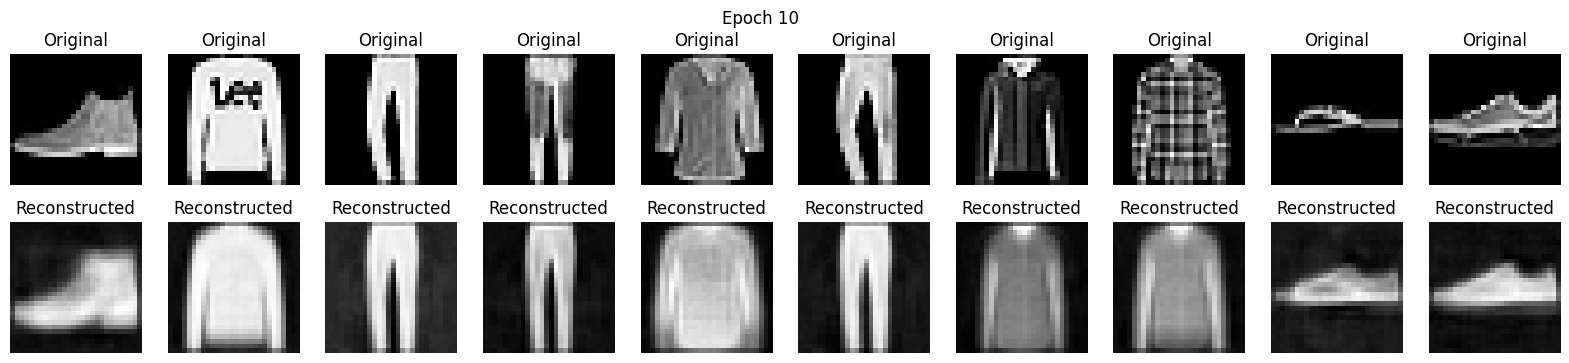

Epoch 11/50 - Training: 100%|██████████| 469/469 [00:29<00:00, 15.67it/s]


Epoch 11/50 - Training Loss: 0.02963198124488661


Epoch 12/50 - Training: 100%|██████████| 469/469 [00:09<00:00, 49.84it/s]


Epoch 12/50 - Training Loss: 0.029525522591431003


Epoch 13/50 - Training: 100%|██████████| 469/469 [00:10<00:00, 45.87it/s]


Epoch 13/50 - Training Loss: 0.029405524203581595


Epoch 14/50 - Training: 100%|██████████| 469/469 [00:30<00:00, 15.34it/s]


Epoch 14/50 - Training Loss: 0.029336747056099653


Epoch 15/50 - Training: 100%|██████████| 469/469 [00:28<00:00, 16.20it/s]


Epoch 15/50 - Training Loss: 0.029101450865996924


Epoch 16/50 - Training: 100%|██████████| 469/469 [00:28<00:00, 16.34it/s]


Epoch 16/50 - Training Loss: 0.029077783350084128


Epoch 17/50 - Training: 100%|██████████| 469/469 [00:31<00:00, 14.90it/s]


Epoch 17/50 - Training Loss: 0.028939181621045446


Epoch 18/50 - Training: 100%|██████████| 469/469 [00:30<00:00, 15.62it/s]


Epoch 18/50 - Training Loss: 0.028786457630235757


Epoch 19/50 - Training: 100%|██████████| 469/469 [00:29<00:00, 15.92it/s]


Epoch 19/50 - Training Loss: 0.02871108292214779


Epoch 20/50 - Training: 100%|██████████| 469/469 [00:30<00:00, 15.58it/s]


Epoch 20/50 - Training Loss: 0.02859130260278421
Epoch 20/50 - Validation Loss: 0.028523388377661947


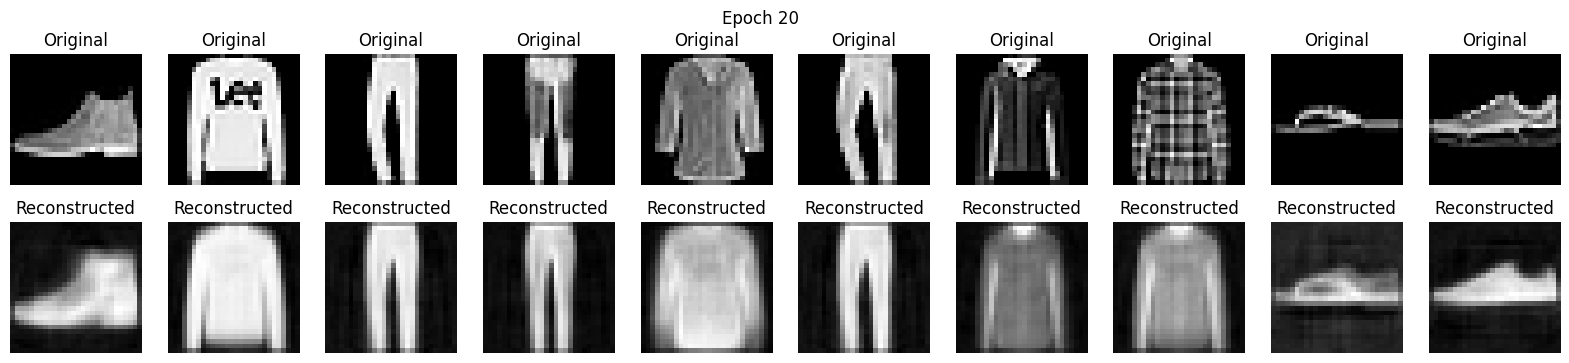

Epoch 21/50 - Training: 100%|██████████| 469/469 [00:29<00:00, 15.71it/s]


Epoch 21/50 - Training Loss: 0.028550665853406067


Epoch 22/50 - Training: 100%|██████████| 469/469 [00:27<00:00, 16.75it/s]


Epoch 22/50 - Training Loss: 0.02847566406355738


Epoch 23/50 - Training: 100%|██████████| 469/469 [00:29<00:00, 16.03it/s]


Epoch 23/50 - Training Loss: 0.02840780089500108


Epoch 24/50 - Training: 100%|██████████| 469/469 [00:30<00:00, 15.53it/s]


Epoch 24/50 - Training Loss: 0.028353126663992655


Epoch 25/50 - Training: 100%|██████████| 469/469 [00:30<00:00, 15.30it/s]


Epoch 25/50 - Training Loss: 0.028196324246810442


Epoch 26/50 - Training: 100%|██████████| 469/469 [00:30<00:00, 15.62it/s]


Epoch 26/50 - Training Loss: 0.0281471294611057


Epoch 27/50 - Training: 100%|██████████| 469/469 [00:29<00:00, 16.08it/s]


Epoch 27/50 - Training Loss: 0.028186398588105052


Epoch 28/50 - Training: 100%|██████████| 469/469 [00:30<00:00, 15.20it/s]


Epoch 28/50 - Training Loss: 0.028045436419022362


Epoch 29/50 - Training: 100%|██████████| 469/469 [00:28<00:00, 16.59it/s]


Epoch 29/50 - Training Loss: 0.027996224178465954


Epoch 30/50 - Training: 100%|██████████| 469/469 [00:24<00:00, 18.83it/s]


Epoch 30/50 - Training Loss: 0.027927646334014976
Epoch 30/50 - Validation Loss: 0.028221956678206407


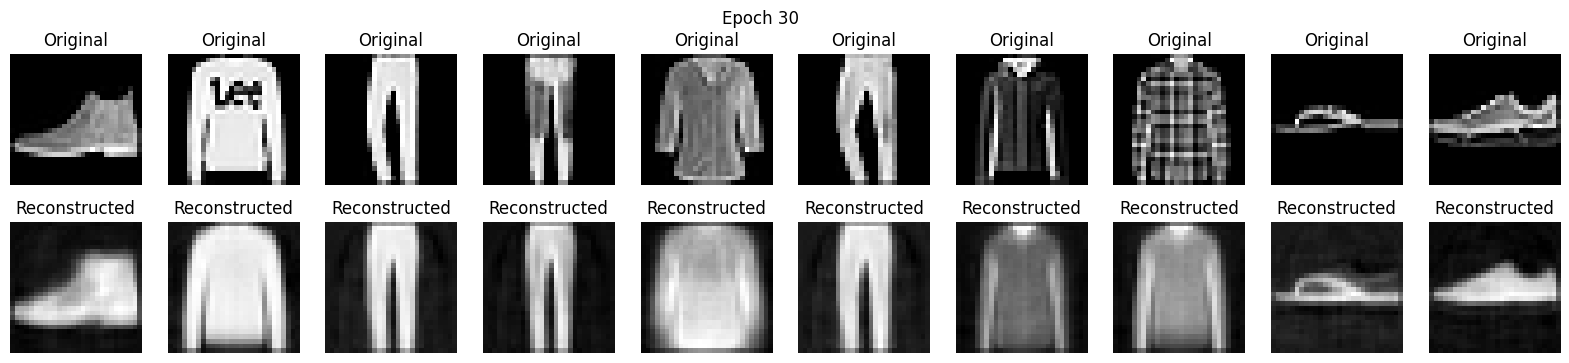

Epoch 31/50 - Training: 100%|██████████| 469/469 [00:28<00:00, 16.40it/s]


Epoch 31/50 - Training Loss: 0.027835403980095503


Epoch 32/50 - Training: 100%|██████████| 469/469 [00:29<00:00, 15.70it/s]


Epoch 32/50 - Training Loss: 0.027730788566918768


Epoch 33/50 - Training: 100%|██████████| 469/469 [00:31<00:00, 14.84it/s]


Epoch 33/50 - Training Loss: 0.0277204899423158


Epoch 34/50 - Training: 100%|██████████| 469/469 [00:31<00:00, 15.05it/s]


Epoch 34/50 - Training Loss: 0.02767773159245438


Epoch 35/50 - Training: 100%|██████████| 469/469 [00:29<00:00, 16.08it/s]


Epoch 35/50 - Training Loss: 0.027669666303214487


Epoch 36/50 - Training: 100%|██████████| 469/469 [00:31<00:00, 14.81it/s]


Epoch 36/50 - Training Loss: 0.02760758618714967


Epoch 37/50 - Training: 100%|██████████| 469/469 [00:31<00:00, 15.04it/s]


Epoch 37/50 - Training Loss: 0.027553797518806673


Epoch 38/50 - Training: 100%|██████████| 469/469 [00:30<00:00, 15.48it/s]


Epoch 38/50 - Training Loss: 0.027490062138705113


Epoch 39/50 - Training: 100%|██████████| 469/469 [00:30<00:00, 15.24it/s]


Epoch 39/50 - Training Loss: 0.027406589106233642


Epoch 40/50 - Training: 100%|██████████| 469/469 [00:31<00:00, 15.02it/s]


Epoch 40/50 - Training Loss: 0.02739991364813944
Epoch 40/50 - Validation Loss: 0.027439664624914338


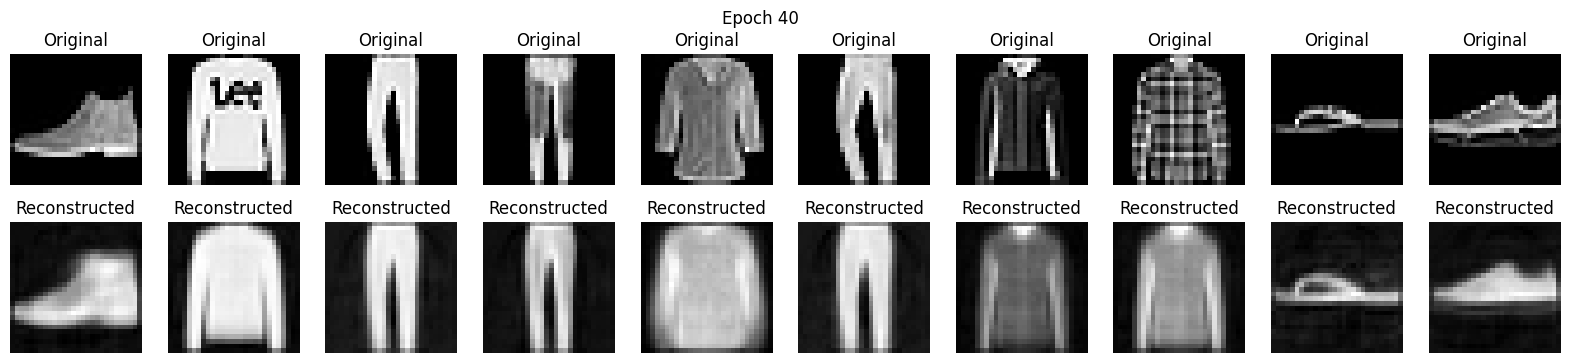

Epoch 41/50 - Training: 100%|██████████| 469/469 [00:30<00:00, 15.58it/s]


Epoch 41/50 - Training Loss: 0.027437605460220053


Epoch 42/50 - Training: 100%|██████████| 469/469 [00:26<00:00, 17.49it/s]


Epoch 42/50 - Training Loss: 0.027369135541956562


Epoch 43/50 - Training: 100%|██████████| 469/469 [00:30<00:00, 15.17it/s]


Epoch 43/50 - Training Loss: 0.027276896543975578


Epoch 44/50 - Training: 100%|██████████| 469/469 [00:34<00:00, 13.75it/s]


Epoch 44/50 - Training Loss: 0.027261763298784745


Epoch 45/50 - Training: 100%|██████████| 469/469 [00:31<00:00, 14.91it/s]


Epoch 45/50 - Training Loss: 0.027235021806760892


Epoch 46/50 - Training: 100%|██████████| 469/469 [00:31<00:00, 15.11it/s]


Epoch 46/50 - Training Loss: 0.0272313095430639


Epoch 47/50 - Training: 100%|██████████| 469/469 [00:30<00:00, 15.32it/s]


Epoch 47/50 - Training Loss: 0.0271914724165252


Epoch 48/50 - Training: 100%|██████████| 469/469 [00:33<00:00, 13.98it/s]


Epoch 48/50 - Training Loss: 0.027235589293973534


Epoch 49/50 - Training: 100%|██████████| 469/469 [00:32<00:00, 14.60it/s]


Epoch 49/50 - Training Loss: 0.02717730337813465


Epoch 50/50 - Training: 100%|██████████| 469/469 [00:32<00:00, 14.49it/s]


Epoch 50/50 - Training Loss: 0.027208171026316532
Epoch 50/50 - Validation Loss: 0.027222498378987554


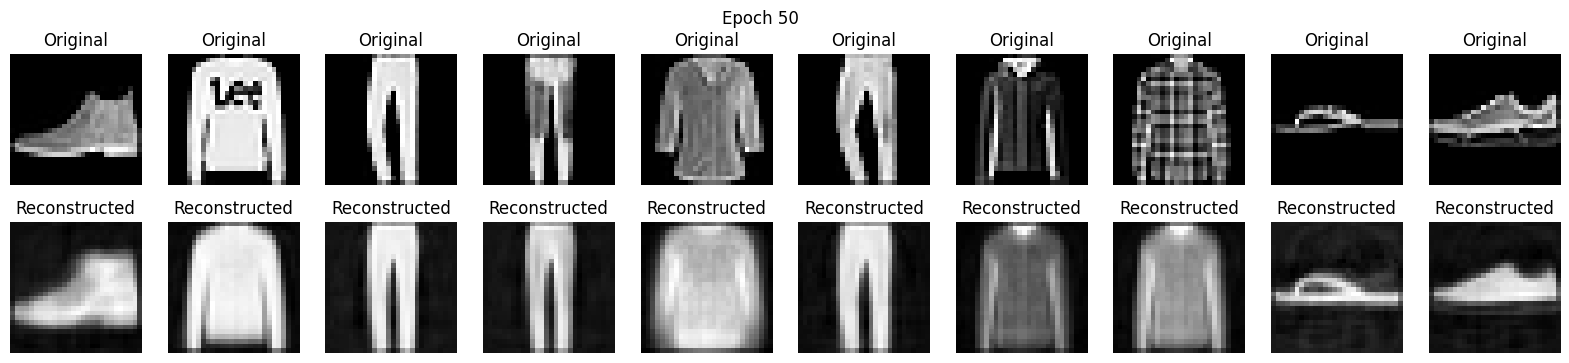

In [5]:
fc_model = Autoencoder()
criterion = nn.MSELoss()
train_loss, val_loss = training_loop(fc_model, train_loader, val_loader, criterion, num_epochs=50)

Epoch 1/50 - Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1/50 - Training: 100%|██████████| 469/469 [00:32<00:00, 14.49it/s]


Epoch 1/50 - Training Loss: 0.05607838545050194
Epoch 1/50 - Validation Loss: 0.03842676841194117


Epoch 2/50 - Training: 100%|██████████| 469/469 [00:32<00:00, 14.60it/s]


Epoch 2/50 - Training Loss: 0.03676477257313251


Epoch 3/50 - Training: 100%|██████████| 469/469 [00:32<00:00, 14.38it/s]


Epoch 3/50 - Training Loss: 0.03440104873735767


Epoch 4/50 - Training: 100%|██████████| 469/469 [00:32<00:00, 14.44it/s]


Epoch 4/50 - Training Loss: 0.03326108693075714


Epoch 5/50 - Training: 100%|██████████| 469/469 [00:34<00:00, 13.78it/s]


Epoch 5/50 - Training Loss: 0.03266276302797073


Epoch 6/50 - Training: 100%|██████████| 469/469 [00:26<00:00, 17.59it/s]


Epoch 6/50 - Training Loss: 0.03209495802185556


Epoch 7/50 - Training: 100%|██████████| 469/469 [00:07<00:00, 63.34it/s]


Epoch 7/50 - Training Loss: 0.03184208610672941


Epoch 8/50 - Training: 100%|██████████| 469/469 [00:07<00:00, 63.69it/s]


Epoch 8/50 - Training Loss: 0.03152644131054629


Epoch 9/50 - Training: 100%|██████████| 469/469 [00:36<00:00, 12.84it/s]


Epoch 9/50 - Training Loss: 0.03117644770551465


Epoch 10/50 - Training: 100%|██████████| 469/469 [00:38<00:00, 12.22it/s]


Epoch 10/50 - Training Loss: 0.03102893119395923
Epoch 10/50 - Validation Loss: 0.0306599128378343


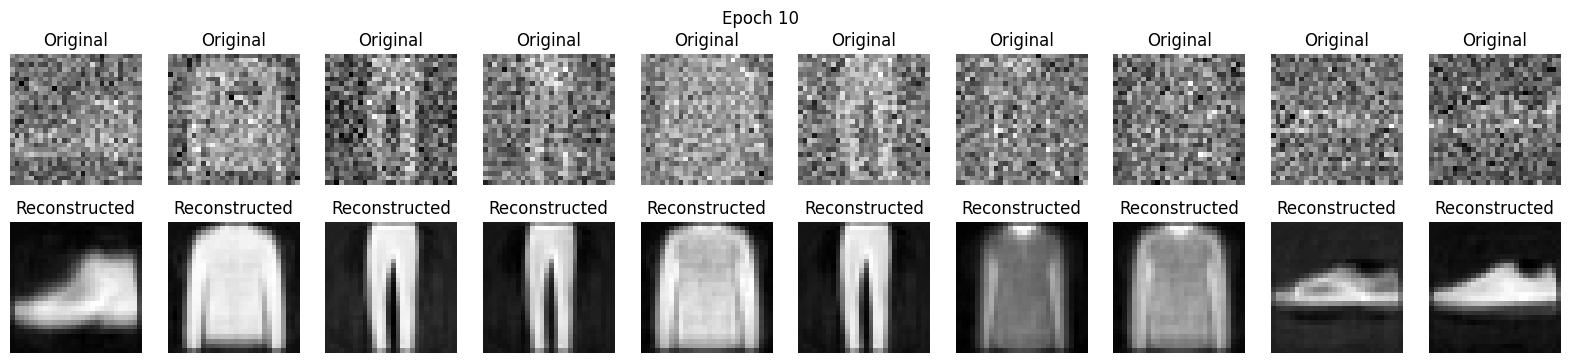

Epoch 11/50 - Training: 100%|██████████| 469/469 [00:33<00:00, 13.86it/s]


Epoch 11/50 - Training Loss: 0.030662194613232288


Epoch 12/50 - Training: 100%|██████████| 469/469 [00:19<00:00, 24.12it/s]


Epoch 12/50 - Training Loss: 0.030240707746796262


Epoch 13/50 - Training: 100%|██████████| 469/469 [00:07<00:00, 65.37it/s]


Epoch 13/50 - Training Loss: 0.028821204048293487


Epoch 14/50 - Training: 100%|██████████| 469/469 [00:20<00:00, 22.92it/s]


Epoch 14/50 - Training Loss: 0.02720751203914314


Epoch 15/50 - Training: 100%|██████████| 469/469 [00:35<00:00, 13.37it/s]


Epoch 15/50 - Training Loss: 0.0264897267185231


Epoch 16/50 - Training: 100%|██████████| 469/469 [00:31<00:00, 14.99it/s]


Epoch 16/50 - Training Loss: 0.026144347854578164


Epoch 17/50 - Training: 100%|██████████| 469/469 [00:31<00:00, 15.12it/s]


Epoch 17/50 - Training Loss: 0.025879866532933737


Epoch 18/50 - Training: 100%|██████████| 469/469 [00:31<00:00, 14.73it/s]


Epoch 18/50 - Training Loss: 0.02564312836953572


Epoch 19/50 - Training: 100%|██████████| 469/469 [00:34<00:00, 13.68it/s]


Epoch 19/50 - Training Loss: 0.02550883549871221


Epoch 20/50 - Training: 100%|██████████| 469/469 [00:31<00:00, 14.93it/s]


Epoch 20/50 - Training Loss: 0.02538315022487376
Epoch 20/50 - Validation Loss: 0.025304523379176477


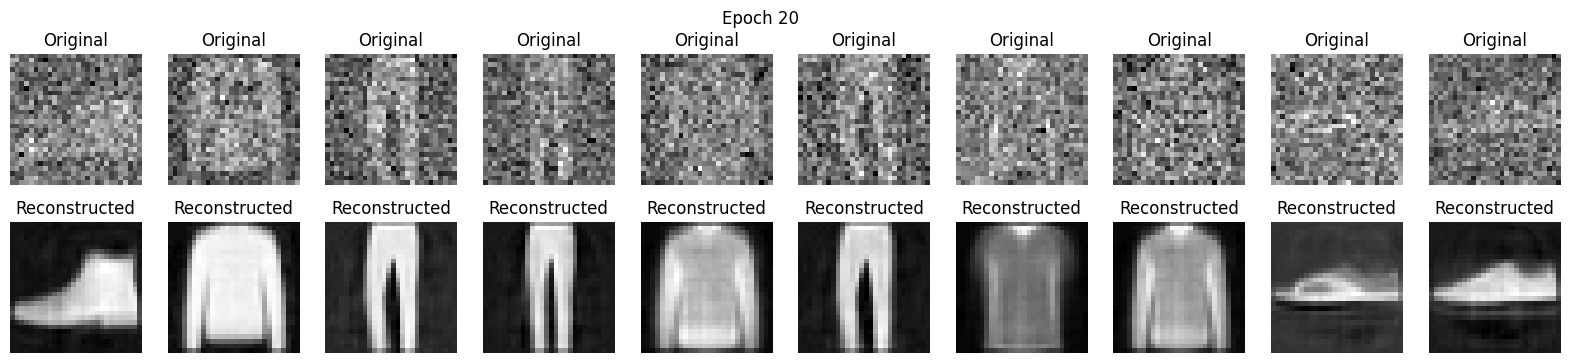

Epoch 21/50 - Training: 100%|██████████| 469/469 [00:07<00:00, 65.53it/s]


Epoch 21/50 - Training Loss: 0.02520943782143374


Epoch 22/50 - Training: 100%|██████████| 469/469 [00:09<00:00, 49.85it/s]


Epoch 22/50 - Training Loss: 0.025071741643745


Epoch 23/50 - Training: 100%|██████████| 469/469 [00:27<00:00, 17.12it/s]


Epoch 23/50 - Training Loss: 0.025007262905396378


Epoch 24/50 - Training: 100%|██████████| 469/469 [00:28<00:00, 16.59it/s]


Epoch 24/50 - Training Loss: 0.024946222673537636


Epoch 25/50 - Training: 100%|██████████| 469/469 [00:24<00:00, 19.03it/s]


Epoch 25/50 - Training Loss: 0.0248267282999909


Epoch 26/50 - Training: 100%|██████████| 469/469 [00:25<00:00, 18.24it/s]


Epoch 26/50 - Training Loss: 0.024721263044043137


Epoch 27/50 - Training: 100%|██████████| 469/469 [00:19<00:00, 24.31it/s]


Epoch 27/50 - Training Loss: 0.024655310576086612


Epoch 28/50 - Training: 100%|██████████| 469/469 [00:06<00:00, 75.23it/s]


Epoch 28/50 - Training Loss: 0.024577843680628327


Epoch 29/50 - Training: 100%|██████████| 469/469 [00:06<00:00, 75.30it/s]


Epoch 29/50 - Training Loss: 0.024497257601191747


Epoch 30/50 - Training: 100%|██████████| 469/469 [00:06<00:00, 74.63it/s]


Epoch 30/50 - Training Loss: 0.024496366446619348
Epoch 30/50 - Validation Loss: 0.02450340972105159


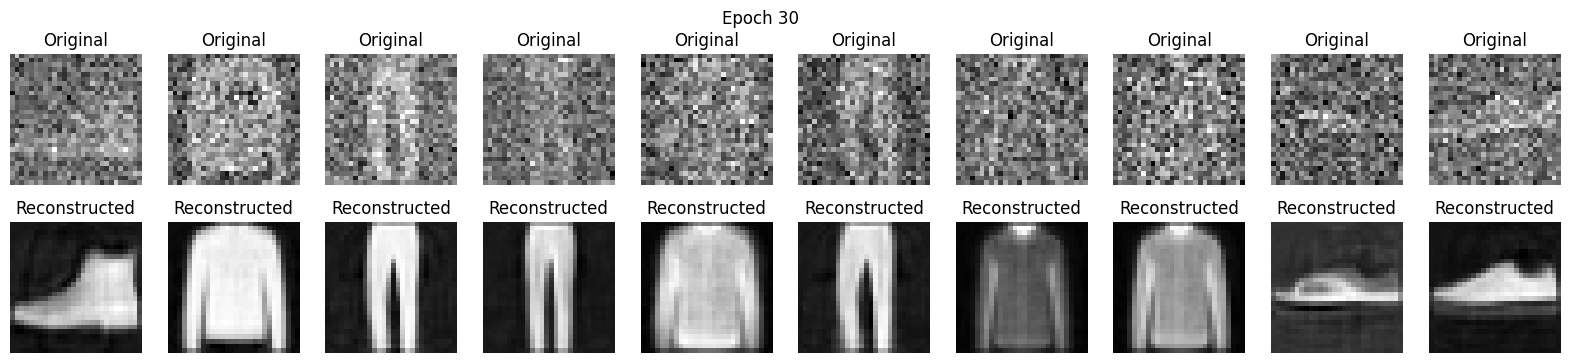

Epoch 31/50 - Training: 100%|██████████| 469/469 [00:06<00:00, 74.04it/s]


Epoch 31/50 - Training Loss: 0.024413400327663686


Epoch 32/50 - Training: 100%|██████████| 469/469 [00:06<00:00, 75.70it/s]


Epoch 32/50 - Training Loss: 0.024368199430453753


Epoch 33/50 - Training: 100%|██████████| 469/469 [00:06<00:00, 75.24it/s]


Epoch 33/50 - Training Loss: 0.024329446009926196


Epoch 34/50 - Training: 100%|██████████| 469/469 [00:06<00:00, 75.30it/s]


Epoch 34/50 - Training Loss: 0.02428977202171329


Epoch 35/50 - Training: 100%|██████████| 469/469 [00:06<00:00, 75.23it/s]


Epoch 35/50 - Training Loss: 0.024261862333458877


Epoch 36/50 - Training: 100%|██████████| 469/469 [00:06<00:00, 76.37it/s]


Epoch 36/50 - Training Loss: 0.024213138522941675


Epoch 37/50 - Training: 100%|██████████| 469/469 [00:06<00:00, 76.04it/s]


Epoch 37/50 - Training Loss: 0.024145518145613325


Epoch 38/50 - Training: 100%|██████████| 469/469 [00:06<00:00, 75.76it/s]


Epoch 38/50 - Training Loss: 0.024185506813625284


Epoch 39/50 - Training: 100%|██████████| 469/469 [00:06<00:00, 75.04it/s]


Epoch 39/50 - Training Loss: 0.02416011397994912


Epoch 40/50 - Training: 100%|██████████| 469/469 [00:06<00:00, 76.09it/s]


Epoch 40/50 - Training Loss: 0.024069004459803037
Epoch 40/50 - Validation Loss: 0.02413232725915275


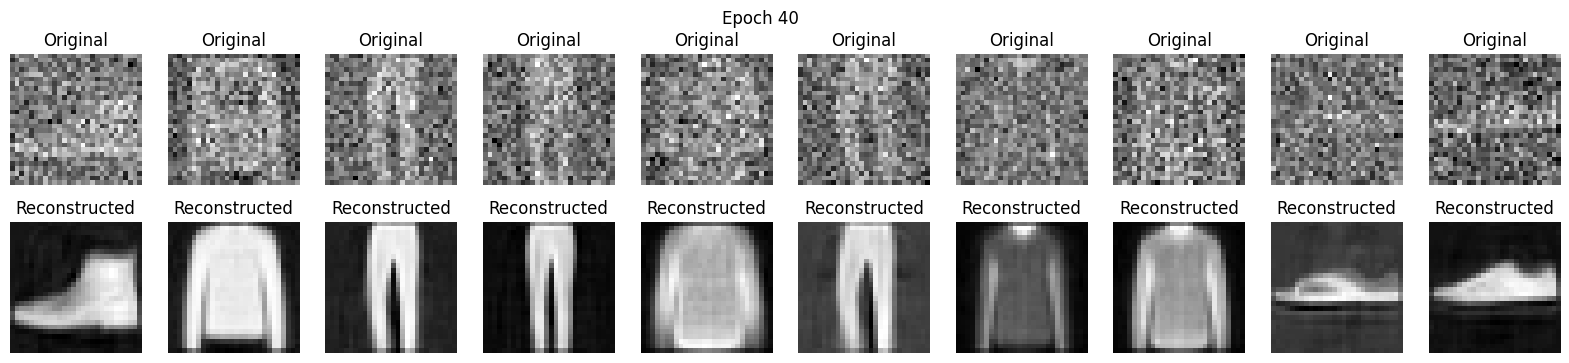

Epoch 41/50 - Training: 100%|██████████| 469/469 [00:06<00:00, 72.99it/s]


Epoch 41/50 - Training Loss: 0.02409576188161302


Epoch 42/50 - Training: 100%|██████████| 469/469 [00:06<00:00, 75.45it/s]


Epoch 42/50 - Training Loss: 0.024031702730892054


Epoch 43/50 - Training: 100%|██████████| 469/469 [00:06<00:00, 75.64it/s]


Epoch 43/50 - Training Loss: 0.024006147680283862


Epoch 44/50 - Training: 100%|██████████| 469/469 [00:06<00:00, 75.84it/s]


Epoch 44/50 - Training Loss: 0.023965074067145015


Epoch 45/50 - Training: 100%|██████████| 469/469 [00:06<00:00, 76.00it/s]


Epoch 45/50 - Training Loss: 0.02396912290565749


Epoch 46/50 - Training: 100%|██████████| 469/469 [00:06<00:00, 75.04it/s]


Epoch 46/50 - Training Loss: 0.023920465673782677


Epoch 47/50 - Training: 100%|██████████| 469/469 [00:06<00:00, 75.03it/s]


Epoch 47/50 - Training Loss: 0.023871735322164064


Epoch 48/50 - Training: 100%|██████████| 469/469 [00:06<00:00, 75.64it/s]


Epoch 48/50 - Training Loss: 0.02386051004549969


Epoch 49/50 - Training: 100%|██████████| 469/469 [00:06<00:00, 75.44it/s]


Epoch 49/50 - Training Loss: 0.023869623499574947


Epoch 50/50 - Training: 100%|██████████| 469/469 [00:06<00:00, 75.03it/s]


Epoch 50/50 - Training Loss: 0.023768238870224466
Epoch 50/50 - Validation Loss: 0.023807860840159126


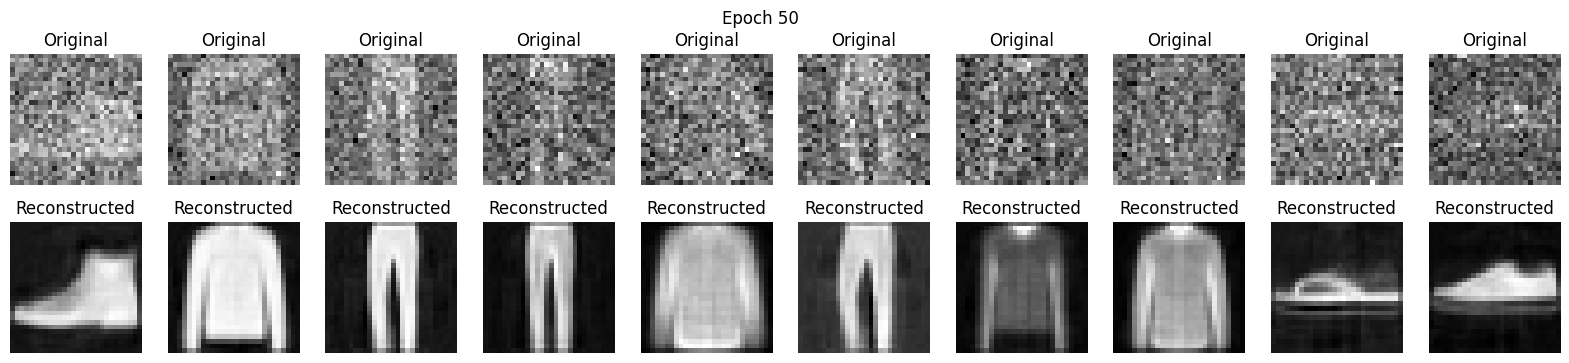

In [6]:
noised_model = Autoencoder()
criterion = nn.MSELoss()
train_loss, val_loss = training_loop(noised_model, train_loader, val_loader, criterion, num_epochs=50, with_noise=True)

While the inputs to the noised fully connected autoencoder may appear blurred due to the added noise, the resulting outputs exhibit similar representations. This is because the neural networks can also learn the noise of the images and learn/keep the most important features of the images, even though the noise.

Autoencoders and other neural network models used for representation learning can be trained to recognize and filter out noise, thereby learning to focus on the most important features of the images. This ability helps the model to generalize better and improve its robustness to noisy data.

In [7]:
class Conv_Autoencoder(nn.Module):
    def __init__(self):
        super(Conv_Autoencoder,self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5),
            nn.ReLU(),

            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=5),
            nn.Flatten(),
            nn.Linear(20*20*8, 10),
            nn.Softmax()
            )
        
        self.decoder = nn.Sequential(
            nn.Linear(10, 400),
            nn.ReLU(),

            nn.Linear(400, 4000),
            nn.ReLU(),

            nn.Unflatten(dim=1, unflattened_size=(10, 20, 20)),
            nn.ConvTranspose2d(in_channels=10, out_channels=10, kernel_size=5),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=10, out_channels=1, kernel_size=5),
            nn.Tanh()
            )
        
    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(x.size(0), *(28,28))
        return x

Epoch 1/50 - Training:   0%|          | 0/469 [00:00<?, ?it/s]c:\Users\kutay\miniconda3\envs\deepl\lib\site-packages\torch\nn\modules\module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Epoch 1/50 - Training: 100%|██████████| 469/469 [00:07<00:00, 62.04it/s]


Epoch 1/50 - Training Loss: 0.03809391318369649
Epoch 1/50 - Validation Loss: 0.024252712372926217


Epoch 2/50 - Training: 100%|██████████| 469/469 [00:06<00:00, 68.10it/s]


Epoch 2/50 - Training Loss: 0.022211825574384822


Epoch 3/50 - Training: 100%|██████████| 469/469 [00:06<00:00, 67.84it/s]


Epoch 3/50 - Training Loss: 0.019869890616043037


Epoch 4/50 - Training: 100%|██████████| 469/469 [00:06<00:00, 68.26it/s]


Epoch 4/50 - Training Loss: 0.018699335808089294


Epoch 5/50 - Training: 100%|██████████| 469/469 [00:06<00:00, 68.10it/s]


Epoch 5/50 - Training Loss: 0.017934818803739826


Epoch 6/50 - Training: 100%|██████████| 469/469 [00:06<00:00, 67.36it/s]


Epoch 6/50 - Training Loss: 0.017370283595725164


Epoch 7/50 - Training: 100%|██████████| 469/469 [00:06<00:00, 68.10it/s]


Epoch 7/50 - Training Loss: 0.01690715380799351


Epoch 8/50 - Training: 100%|██████████| 469/469 [00:07<00:00, 65.56it/s]


Epoch 8/50 - Training Loss: 0.016554546607995848


Epoch 9/50 - Training: 100%|██████████| 469/469 [00:07<00:00, 63.93it/s]


Epoch 9/50 - Training Loss: 0.016232555009313483


Epoch 10/50 - Training: 100%|██████████| 469/469 [00:07<00:00, 66.33it/s]


Epoch 10/50 - Training Loss: 0.015986376273225366
Epoch 10/50 - Validation Loss: 0.016259489663511137


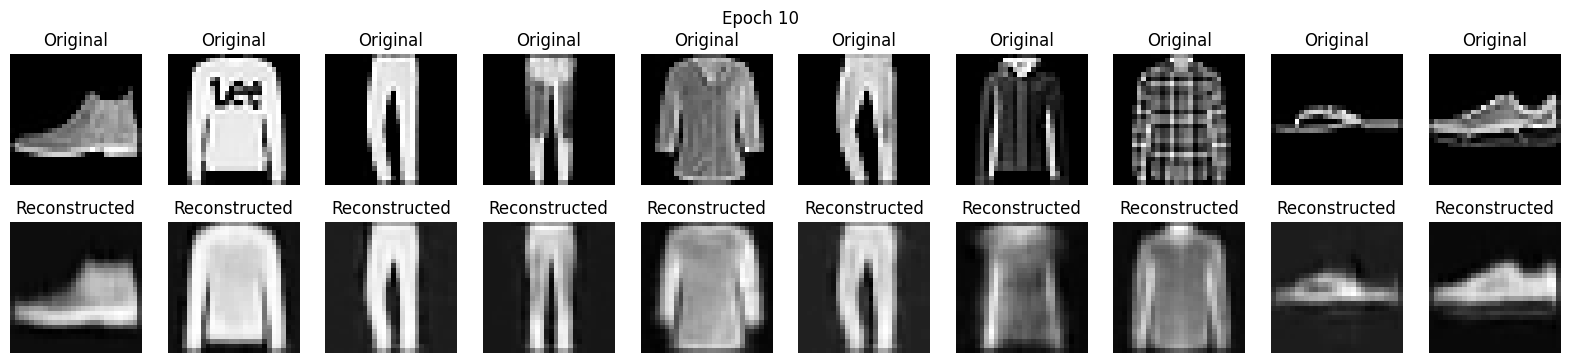

Epoch 11/50 - Training: 100%|██████████| 469/469 [00:07<00:00, 66.85it/s]


Epoch 11/50 - Training Loss: 0.015771263896592898


Epoch 12/50 - Training: 100%|██████████| 469/469 [00:07<00:00, 66.88it/s]


Epoch 12/50 - Training Loss: 0.01553204886392871


Epoch 13/50 - Training: 100%|██████████| 469/469 [00:07<00:00, 66.92it/s]


Epoch 13/50 - Training Loss: 0.015355103490338015


Epoch 14/50 - Training: 100%|██████████| 469/469 [00:06<00:00, 67.01it/s]


Epoch 14/50 - Training Loss: 0.015201358944733642


Epoch 15/50 - Training: 100%|██████████| 469/469 [00:07<00:00, 66.99it/s]


Epoch 15/50 - Training Loss: 0.01509560594188252


Epoch 16/50 - Training: 100%|██████████| 469/469 [00:06<00:00, 67.16it/s]


Epoch 16/50 - Training Loss: 0.01497496379368595


Epoch 17/50 - Training: 100%|██████████| 469/469 [00:07<00:00, 66.87it/s]


Epoch 17/50 - Training Loss: 0.014869852045149819


Epoch 18/50 - Training: 100%|██████████| 469/469 [00:06<00:00, 67.18it/s]


Epoch 18/50 - Training Loss: 0.014795244683318937


Epoch 19/50 - Training: 100%|██████████| 469/469 [00:07<00:00, 66.63it/s]


Epoch 19/50 - Training Loss: 0.014716530308079744


Epoch 20/50 - Training: 100%|██████████| 469/469 [00:06<00:00, 67.03it/s]


Epoch 20/50 - Training Loss: 0.014653089418530718
Epoch 20/50 - Validation Loss: 0.014866237729033338


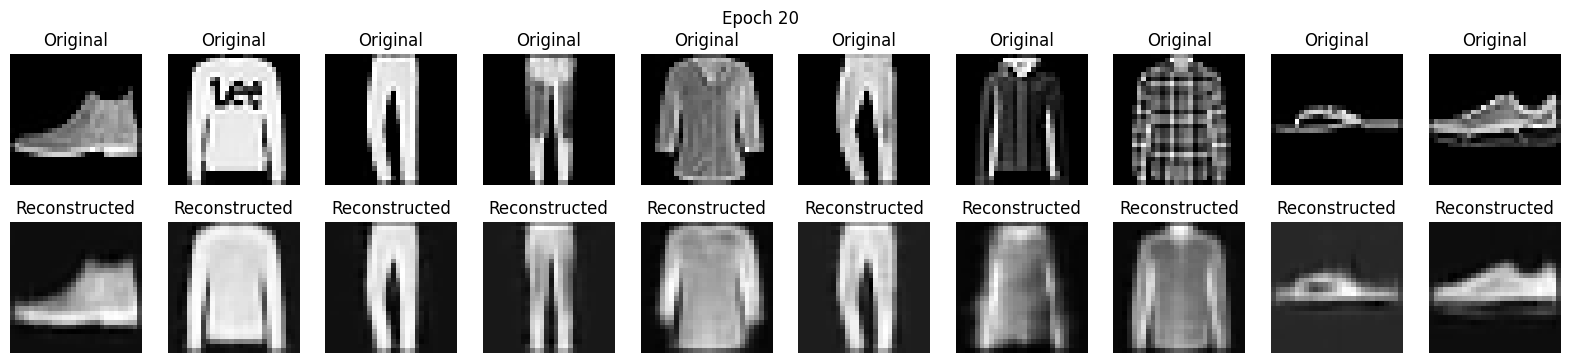

Epoch 21/50 - Training: 100%|██████████| 469/469 [00:07<00:00, 66.95it/s]


Epoch 21/50 - Training Loss: 0.014586078080493631


Epoch 22/50 - Training: 100%|██████████| 469/469 [00:07<00:00, 66.74it/s]


Epoch 22/50 - Training Loss: 0.014524971879621559


Epoch 23/50 - Training: 100%|██████████| 469/469 [00:06<00:00, 67.01it/s]


Epoch 23/50 - Training Loss: 0.014491605129577458


Epoch 24/50 - Training: 100%|██████████| 469/469 [00:07<00:00, 66.97it/s]


Epoch 24/50 - Training Loss: 0.014421653939780395


Epoch 25/50 - Training: 100%|██████████| 469/469 [00:07<00:00, 66.94it/s]


Epoch 25/50 - Training Loss: 0.014385570432426832


Epoch 26/50 - Training: 100%|██████████| 469/469 [00:07<00:00, 66.79it/s]


Epoch 26/50 - Training Loss: 0.014383727364909293


Epoch 27/50 - Training: 100%|██████████| 469/469 [00:07<00:00, 66.75it/s]


Epoch 27/50 - Training Loss: 0.014323197740084453


Epoch 28/50 - Training: 100%|██████████| 469/469 [00:06<00:00, 67.26it/s]


Epoch 28/50 - Training Loss: 0.014274356479663203


Epoch 29/50 - Training: 100%|██████████| 469/469 [00:07<00:00, 66.58it/s]


Epoch 29/50 - Training Loss: 0.014282798609023156


Epoch 30/50 - Training: 100%|██████████| 469/469 [00:07<00:00, 66.86it/s]


Epoch 30/50 - Training Loss: 0.014230895930452387
Epoch 30/50 - Validation Loss: 0.014440526242686224


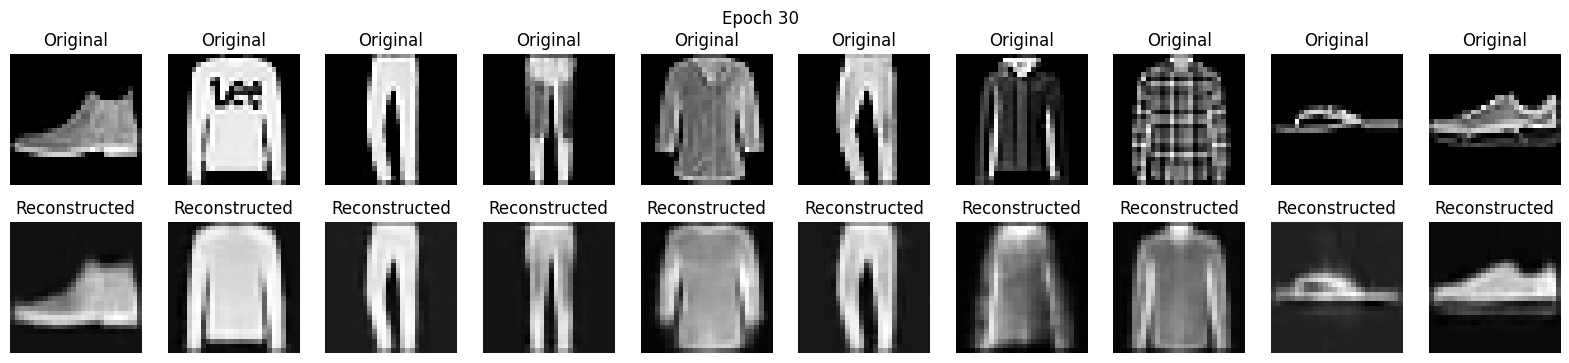

Epoch 31/50 - Training: 100%|██████████| 469/469 [00:07<00:00, 66.86it/s]


Epoch 31/50 - Training Loss: 0.014212340100614755


Epoch 32/50 - Training: 100%|██████████| 469/469 [00:07<00:00, 66.90it/s]


Epoch 32/50 - Training Loss: 0.014187188713805381


Epoch 33/50 - Training: 100%|██████████| 469/469 [00:06<00:00, 67.08it/s]


Epoch 33/50 - Training Loss: 0.014187556830471132


Epoch 34/50 - Training: 100%|██████████| 469/469 [00:07<00:00, 66.43it/s]


Epoch 34/50 - Training Loss: 0.014155272181942138


Epoch 35/50 - Training: 100%|██████████| 469/469 [00:06<00:00, 67.05it/s]


Epoch 35/50 - Training Loss: 0.01413038970310805


Epoch 36/50 - Training: 100%|██████████| 469/469 [00:07<00:00, 66.82it/s]


Epoch 36/50 - Training Loss: 0.014106559527438205


Epoch 37/50 - Training: 100%|██████████| 469/469 [00:07<00:00, 66.65it/s]


Epoch 37/50 - Training Loss: 0.014109229897337554


Epoch 38/50 - Training: 100%|██████████| 469/469 [00:07<00:00, 66.92it/s]


Epoch 38/50 - Training Loss: 0.014099674249715262


Epoch 39/50 - Training: 100%|██████████| 469/469 [00:07<00:00, 66.83it/s]


Epoch 39/50 - Training Loss: 0.014076146904800111


Epoch 40/50 - Training: 100%|██████████| 469/469 [00:06<00:00, 67.33it/s]


Epoch 40/50 - Training Loss: 0.01404777065769378
Epoch 40/50 - Validation Loss: 0.014377438368959517


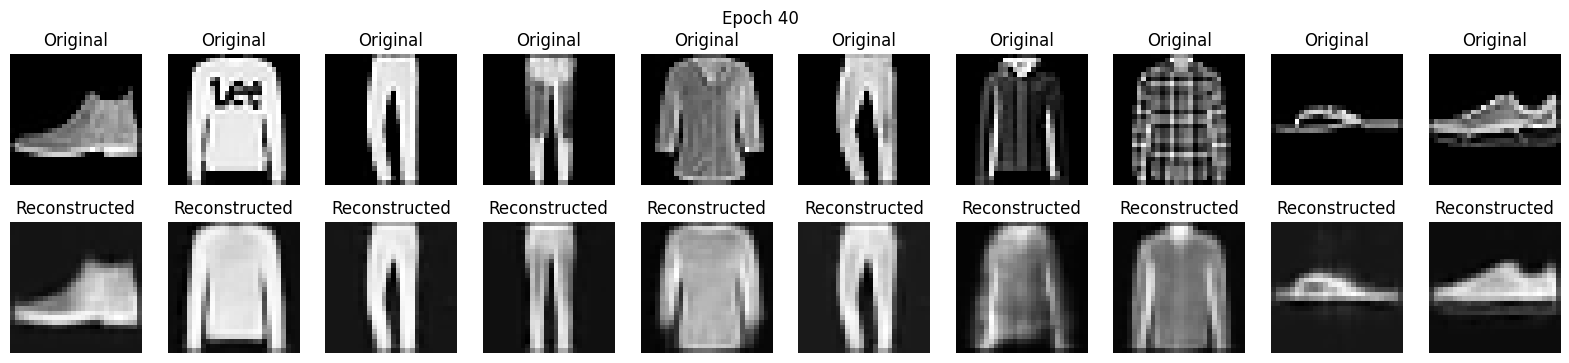

Epoch 41/50 - Training: 100%|██████████| 469/469 [00:07<00:00, 66.58it/s]


Epoch 41/50 - Training Loss: 0.014038156614756025


Epoch 42/50 - Training: 100%|██████████| 469/469 [00:06<00:00, 67.40it/s]


Epoch 42/50 - Training Loss: 0.014028791042326736


Epoch 43/50 - Training: 100%|██████████| 469/469 [00:07<00:00, 65.55it/s]


Epoch 43/50 - Training Loss: 0.01401253640532557


Epoch 44/50 - Training: 100%|██████████| 469/469 [00:07<00:00, 66.61it/s]


Epoch 44/50 - Training Loss: 0.013989611203148802


Epoch 45/50 - Training: 100%|██████████| 469/469 [00:06<00:00, 67.31it/s]


Epoch 45/50 - Training Loss: 0.01400695114668562


Epoch 46/50 - Training: 100%|██████████| 469/469 [00:06<00:00, 67.09it/s]


Epoch 46/50 - Training Loss: 0.013984579990095676


Epoch 47/50 - Training: 100%|██████████| 469/469 [00:07<00:00, 66.58it/s]


Epoch 47/50 - Training Loss: 0.013954442594128886


Epoch 48/50 - Training: 100%|██████████| 469/469 [00:06<00:00, 67.01it/s]


Epoch 48/50 - Training Loss: 0.013960422731554711


Epoch 49/50 - Training: 100%|██████████| 469/469 [00:07<00:00, 66.75it/s]


Epoch 49/50 - Training Loss: 0.013952234998218287


Epoch 50/50 - Training: 100%|██████████| 469/469 [00:07<00:00, 65.76it/s]


Epoch 50/50 - Training Loss: 0.013947794658701811
Epoch 50/50 - Validation Loss: 0.014233698726549178


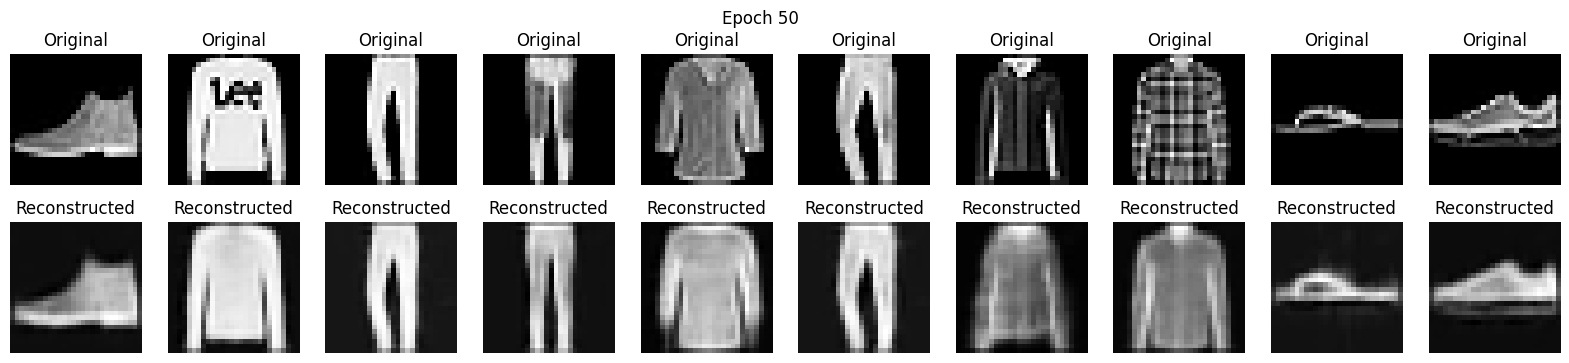

In [8]:
cnn_model = Conv_Autoencoder()
criterion = nn.MSELoss()
train_loss, val_loss = training_loop(cnn_model, train_loader, val_loader, criterion, num_epochs=50)

 CNNs provide more precise predictions, lower loss, and higher accuracy compared to linear autoencoders. This improvement stems from the superior feature-capturing capabilities of convolutional layers, which excel at extracting spatial patterns and hierarchical representations from the input data.